## Лабораторная работа № 6: Кластеризация
### Кузема
#### Импорт пакетов

In [2]:
import numpy as np
import pandas as pd
# процедура стандартизации
from sklearn.preprocessing import StandardScaler
# алгоритм k-средних
from sklearn.cluster import KMeans
# алгоритм k-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
# дендрограмма
from scipy.cluster.hierarchy import dendrogram, linkage
# дендрограмма, расчет матрицы расстояний
from scipy.spatial.distance import pdist
# метрики
from sklearn import metrics 
# кластерные силуэты
from matplotlib import cm 
from sklearn.metrics import silhouette_samples
from matplotlib import pyplot as plt
import seaborn
seaborn.set_theme()

### 1. Скачаем данные load_wine

In [3]:
from sklearn.datasets import load_wine 
data = load_wine()
data

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

### Описание исследуемых показателей
 1) alcohol - Алкоголь
 2) malic_acid - яблочная кислота
 3) ash - Ясень
 4) alcalinity_of_ash - Щелочность золы
 5) magnesium - Магний
 6) total_phenols - Общие фенолы
 7) flavanoids - Flavanoids  
 8) nonflavanoid_phenols - нефлаваноидные фенолы
 9) proanthocyanins - Proanthocyanins 
 10) color_intensity - Интенсивность цвета
 11) hue - оттенок
 12) od280/od315_of_diluted_wines - OD280 / OD315 разбавленных вин Спектральное измерение белка / концентрации разбавленных вин
 13) proline - Пролин



Задача состоит в разделении вин в зависимости от показателей яблочной кислоты и ясени (Malic acid; Ash)

In [4]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df = df[["malic_acid", "ash"]]
df

,malic_acid,ash
0,1.71,2.43
1,1.78,2.14
2,2.36,2.67
3,1.95,2.50
4,2.59,2.87
...,...,...
173,5.65,2.45
174,3.91,2.48
175,4.28,2.26
176,2.59,2.37



### 2. Построим диаграмму  рассеивания по двум базовым показательям яблочной кислоты и ясени (Malic acid; Ash)


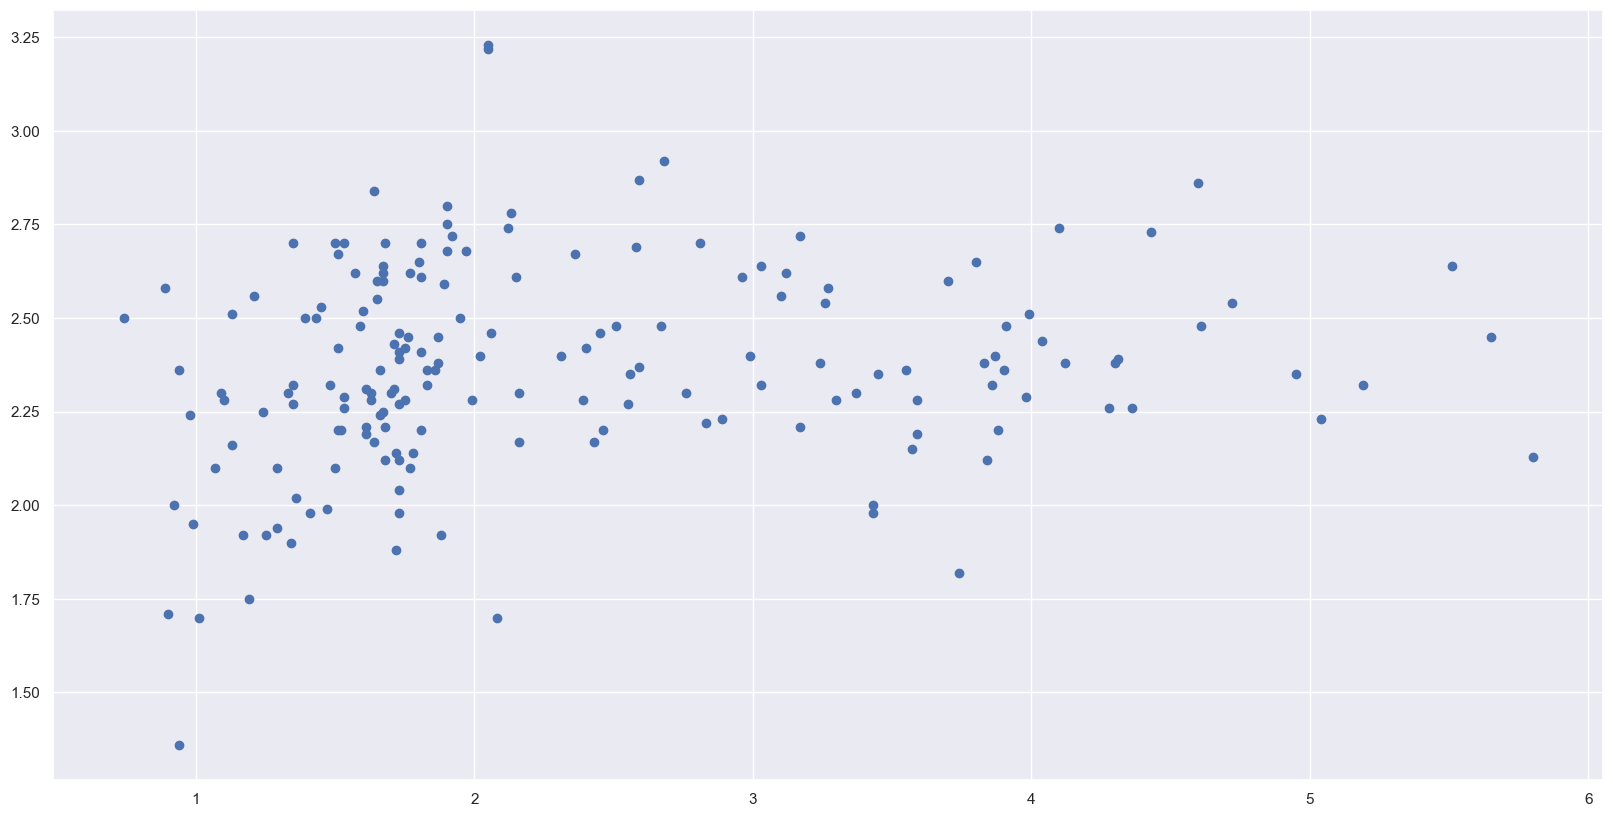

In [5]:
plt.figure(figsize=(20,10))
plt.scatter(df.malic_acid, df.ash)

#### В нашем примере наблюдения визуально сгруппированы на 3 группы (К1). Рассмотрим метод для определения наилучшего количества кластеров.

### 3. Определение оптимального количества кластеров по методу локтя
Одна из основных трудностей в обучении без учителя состоит в том, что мы не знаем точного ответа. В нашем наборе данных нет 
установленных данных о метках классов, поэтому для количественного определения качества кластеризации нам нужно использовать внутренние метрики - такие как внутрикластерная **SSE** (искажение или инерция):
$$SSE = \sum\limits_{i=1}^n\sum\limits_{j=1}^kw_{ij}(x_i - m_i)^2$$
Здесь $w_{ij}$ = 1, если наблюдение относится к кластеру $j$ и 0 в противоположном случае, а $m_i$ - центроид кластера.

Основываясь на внутрикластерной SSE, мы можем применить графический инструмент, так называемый метод локтя, для оценки оптимального числа k кластеров для поставленной задачи. Интуитивно мы можем сказать, что если k увеличивается, то искажение уменьшается. Это вызвано тем, что образцы будут ближе к центроидам, которым они назначены. В основе метода локтя лежит идея, которая состоит в том, чтобы идентифицировать значение k в точке, где искажение начинает увеличиваться быстрее всего, что станет понятнее, если мы построим график искажения для разных значений k.

Text(0, 0.5, 'Искажение ')

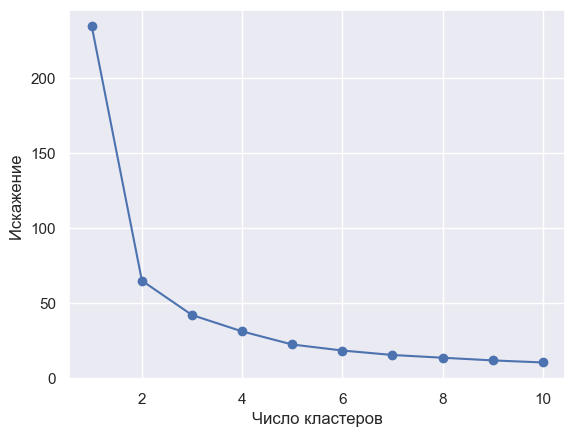

In [6]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(df)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel ('Искажение ' ) 


#### Как видно на графике, локоть расположен в k = 5, что свидетельствует о том, что k = 5 является хорошим выбором для этого набора данных. (K2)

### 4. Проведём кластеризацию методом К-средних и рассчитаем средний силуэтный коэффициент.

#### для k = 3 (K1).


Средний коэффициент силуэта --  0.5429257045205345


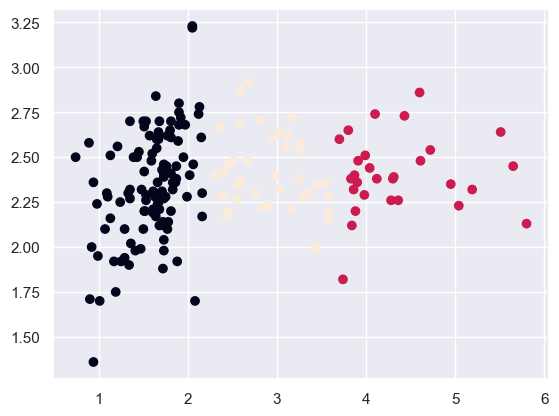

In [7]:
# кластеризация методом К-средних
kmeans = KMeans(n_clusters=3,random_state=0).fit(df.values)
plt.scatter(df.malic_acid, df.ash, c=kmeans.labels_)

#Расчёт среднего силуэтного коэффициента
# метки кластеров для каждого наблюдения
y_km = kmeans.fit_predict(df) 

silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 

print ("Средний коэффициент силуэта -- ", silhouette_avg)

#### для k = 5 (K2).

Средний коэффициент силуэта --  0.4359889872029373


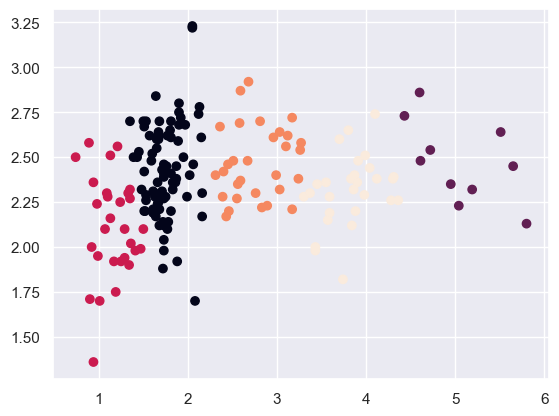

In [8]:
# кластеризация методом К-средних
kmeans = KMeans(n_clusters=5,random_state=0).fit(df.values)
plt.scatter(df.malic_acid, df.ash, c=kmeans.labels_)

#Расчёт среднего силуэтного коэффициента
# метки кластеров для каждого наблюдения
y_km = kmeans.fit_predict(df) 

silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 

print ("Средний коэффициент силуэта -- ", silhouette_avg)

#### Средний коэффициент силуэта при k = 3 (K1) выше, чем при k = 5 (K2), поэтому формально k = 3 (K1) наиболее удачное разбиение. 

### 5. Построим диаграмму рассеивания для выбранного варианта разбиения, на которой наблюденияиз разных кластеров будут выделены соответствующими цветами, и нанесены центроиды.

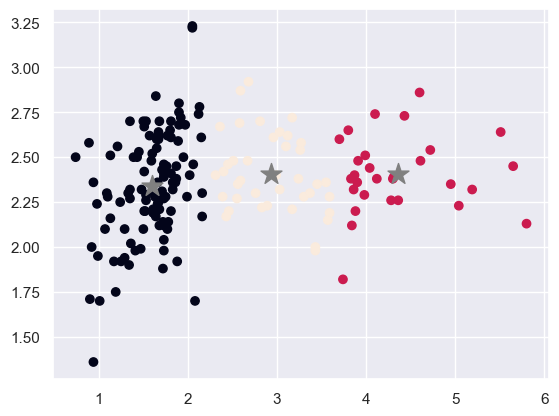

In [9]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df.values)
plt.scatter(df.malic_acid, df.ash, c=kmeans.labels_)
# нарисуем центроиды
plt.scatter(kmeans.cluster_centers_ [:, 0], kmeans.cluster_centers_ [:, 1], 
           s=250, marker= '*', c = 'grey', label = 'центроиды') 

### 6. Добавим к выборке дополнительный показатель  щелочности золы (Alcalinity of ash) и разделим выборку на обучающую и прогнозную в соотношении 80% - 20%.

In [10]:
# Добавление к выборке дополнительный показатель  щелочности золы (Alcalinity of ash) 
DF = pd.DataFrame(data.data, columns=data.feature_names)
DF = DF[["malic_acid", "ash", "alcalinity_of_ash"]]
print(DF)

# Разделение выборки на обучающую и прогнозную в соотношении 80% - 20%
DF_train = DF.sample(frac=0.8)

# данные для прогнозов
DF_predict = DF.drop(DF_train.index)

     malic_acid   ash  alcalinity_of_ash
0          1.71  2.43               15.6
1          1.78  2.14               11.2
2          2.36  2.67               18.6
3          1.95  2.50               16.8
4          2.59  2.87               21.0
..          ...   ...                ...
173        5.65  2.45               20.5
174        3.91  2.48               23.0
175        4.28  2.26               20.0
176        2.59  2.37               20.0
177        4.10  2.74               24.5

[178 rows x 3 columns]


### 7. Определение оптимального количества кластеров по методу локтя

Text(0, 0.5, 'Искажение ')

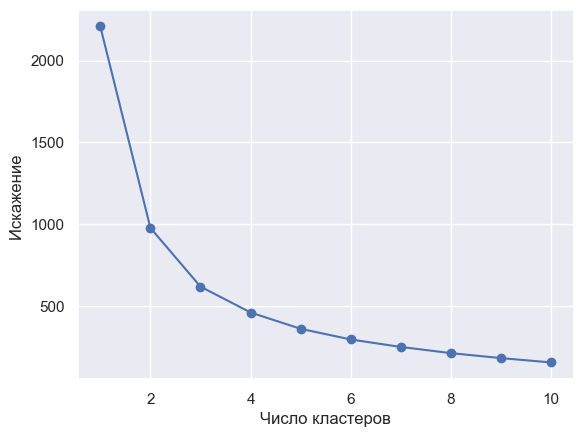

In [11]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(DF)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel ('Искажение ' ) 

#### По сравнению с графиком метода локтя для двух признаков на графике для трёх признаков наблюдается более плавный спуск, и оптимальное число кластеров снизилось с 5 до 4.

### 8-9.Проведём  кластеризацию  на  обучающей и прогнозной  выборке и сравним средний силуэтный коэффициент. 

In [12]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(DF_train.values)
y_km_train = kmeans.fit_predict(DF_train)

silhouette_vals = silhouette_samples(DF_train, y_km_train, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта на обучающей выборке-- ", silhouette_avg)

y_km_predict = kmeans.fit_predict(DF_predict) 
silhouette_vals = silhouette_samples(DF_predict, y_km_predict, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта на прогнозной выборке-- ", silhouette_avg)

Средний коэффициент силуэта на обучающей выборке--  0.3925763875714156
Средний коэффициент силуэта на прогнозной выборке--  0.436624963357099


Средний коэффициент силуэта выше на прогнозной выборке.

### Визуально проанализируем статистическое распределение в кластерах для обучающей выборке.

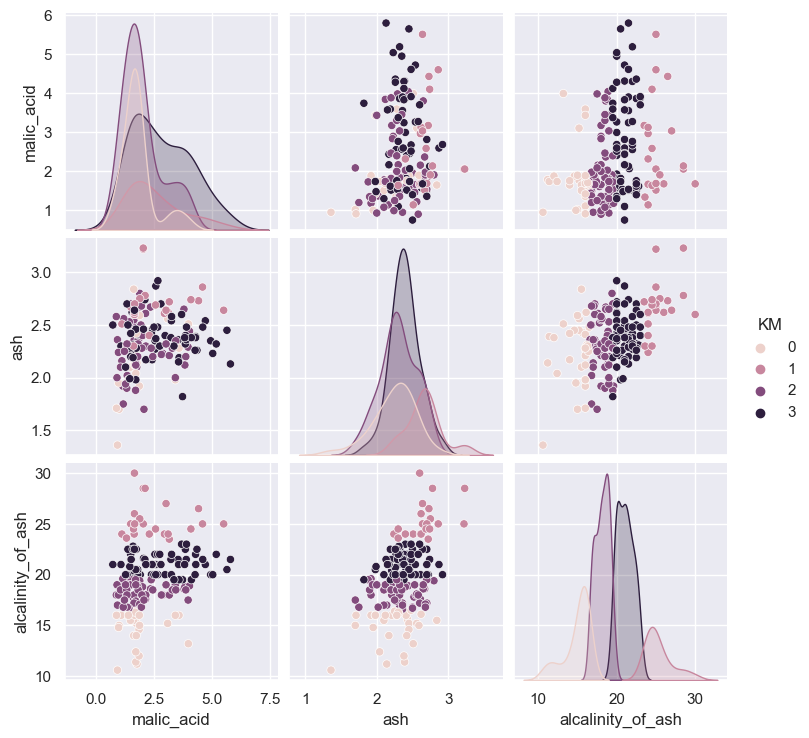

In [13]:
# снова работаем со всей выборкой
# добавляем метки кластеров в качестве нового столбца к фрейму
kmeans = KMeans(n_clusters=4,random_state=0).fit(DF.values)
DF["KM"] = kmeans.fit_predict(DF) 

seaborn.pairplot(DF, hue='KM')
plt.show()

Визуально каждый кластер не
значительно отличается от прочих. Судя по графикам плотности, по показателю **ash** довольно схожи кластеры 0 и 1, а по **alcalinity_of_ash** - 2 и 3. По диаграммам разброса видно, что каждый из 4 кластеров не образует отдельное плотное множество точек, разбиение не строгое.


### (Дополнительное задание) Проведём оценку точности кластеризации с помощью Acc, сравнив оценки с фактическим разбиением на группы

In [14]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=4, random_state=0)

# Обучение модели на данных
kmeans.fit(df)
preds = kmeans.predict(df)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.39325842696629215


In [15]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=4, random_state=0)

# Обучение модели на данных
kmeans.fit(DF)
preds = kmeans.predict(DF)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.14606741573033707


In [16]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=3, random_state=0)

# Обучение модели на данных
kmeans.fit(df)
preds = kmeans.predict(df)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.4606741573033708


In [17]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=3, random_state=0)

# Обучение модели на данных
kmeans.fit(DF)
preds = kmeans.predict(DF)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.3146067415730337


In [18]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=2, random_state=0)

# Обучение модели на данных
kmeans.fit(df)
preds = kmeans.predict(df)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.3595505617977528


In [19]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=2, random_state=0)

# Обучение модели на данных
kmeans.fit(DF)
preds = kmeans.predict(DF)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.2303370786516854


In [20]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=5, random_state=0)

# Обучение модели на данных
kmeans.fit(df)
preds = kmeans.predict(df)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.29775280898876405


In [21]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=5, random_state=0)

# Обучение модели на данных
kmeans.fit(DF)
preds = kmeans.predict(DF)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.14606741573033707


Из оценки кластеризации следует, что алгоритм(при разбиении на 3 кластера с двумя базовыми признаками) имеет наиболее высокую точность (=0.398876404494382). Тем не менее это низкое значение, что указывает на неправильную категоризацию большинства объектов данных.